In [12]:
import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd

# Directory containing the TIFF files
tiff_dir = "E:\\Europe Validation\\MIRCA_OS"

# Path to the shapefile
shapefile_path = "E:\\Europe Validation\\MIRCA_OS\\Export_Output.shp"

# Directory to save the clipped TIFF files
output_dir = "E:\\Europe Validation\\MIRCA-OS_Clipped"
os.makedirs(output_dir, exist_ok=True)

# Read the shapefile using Geopandas
shapefile = gpd.read_file(shapefile_path)

# Loop over each TIFF file in the directory
for tiff_file in os.listdir(tiff_dir):
    if tiff_file.endswith('.tif'):
        tiff_path = os.path.join(tiff_dir, tiff_file)
        
        # Open the TIFF file
        with rasterio.open(tiff_path) as src:
            # Ensure the shapefile and raster have the same CRS
            if shapefile.crs != src.crs:
                shapefile = shapefile.to_crs(src.crs)
            
            # Loop over each feature in the shapefile
            for idx, row in shapefile.iterrows():
                # Get the geometry of the feature
                geom = [row['geometry']]
                
                try:
                    # Clip the TIFF file using the geometry
                    out_image, out_transform = mask(src, geom, crop=True)
                    
                    # Check if the clipped image contains valid data
                    if not out_image.any():
                        print(f"No valid data in clipped result for feature {idx} in {tiff_file}")
                        continue

                    # Copy the metadata
                    out_meta = src.meta.copy()
                    
                    # Update the metadata with the new dimensions, transform, and CRS
                    out_meta.update({
                        "driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform
                    })
                    
                    # Define the output path
                    output_filename = f"clipped_{os.path.splitext(tiff_file)[0]}_feature_{idx}.tif"
                    output_path = os.path.join(output_dir, output_filename)
                    
                    # Save the clipped TIFF file
                    with rasterio.open(output_path, "w", **out_meta) as dest:
                        dest.write(out_image)
                except Exception as e:
                    print(f"Error clipping {tiff_file} for feature {idx}: {e}")

print("Clipping completed.")


Clipping completed.


C:\Users\endal\anaconda3\envs\mirca_2015\lib\site-packages\geopandas\plotting.py:482: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.draw()
C:\Users\endal\AppData\Local\Temp\ipykernel_22548\4225455748.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(labels, fontsize=16)
C:\Users\endal\AppData\Local\Temp\ipykernel_22548\4225455748.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_yticklabels([f'{int(tick)}%' for tick in ax_bar.get_yticks()], fontsize=16)
C:\Users\endal\anaconda3\envs\mirca_2015\lib\site-packages\geopandas\plotting.py:482: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.draw()
C:\Users\endal\AppData\Local\Temp\ipykernel_22548\4225455748.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(labels, fontsize=16)
C:\Users\endal\AppData\Local\Temp\ipykernel_22548\422

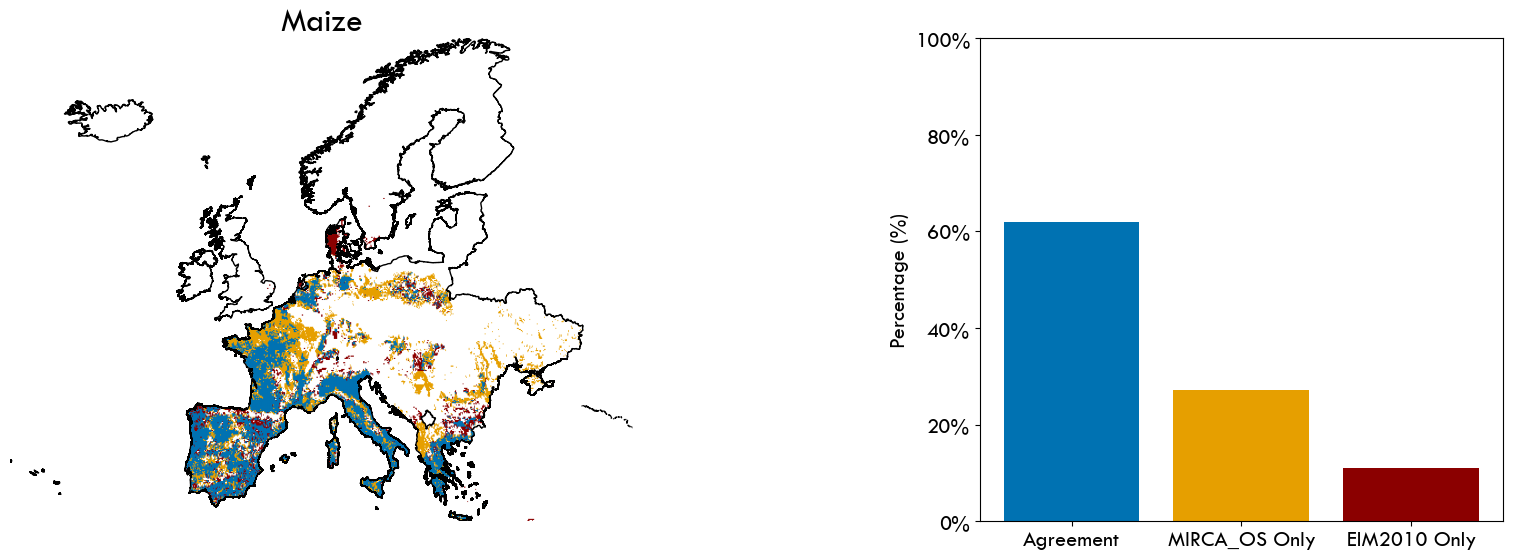

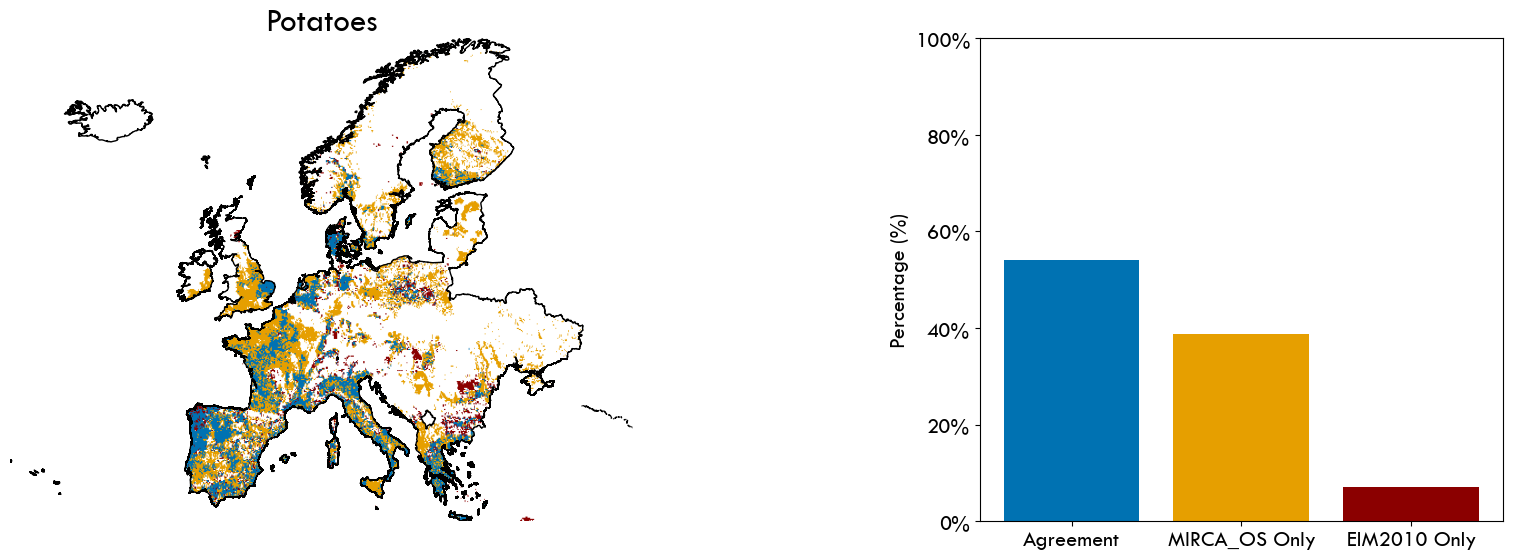

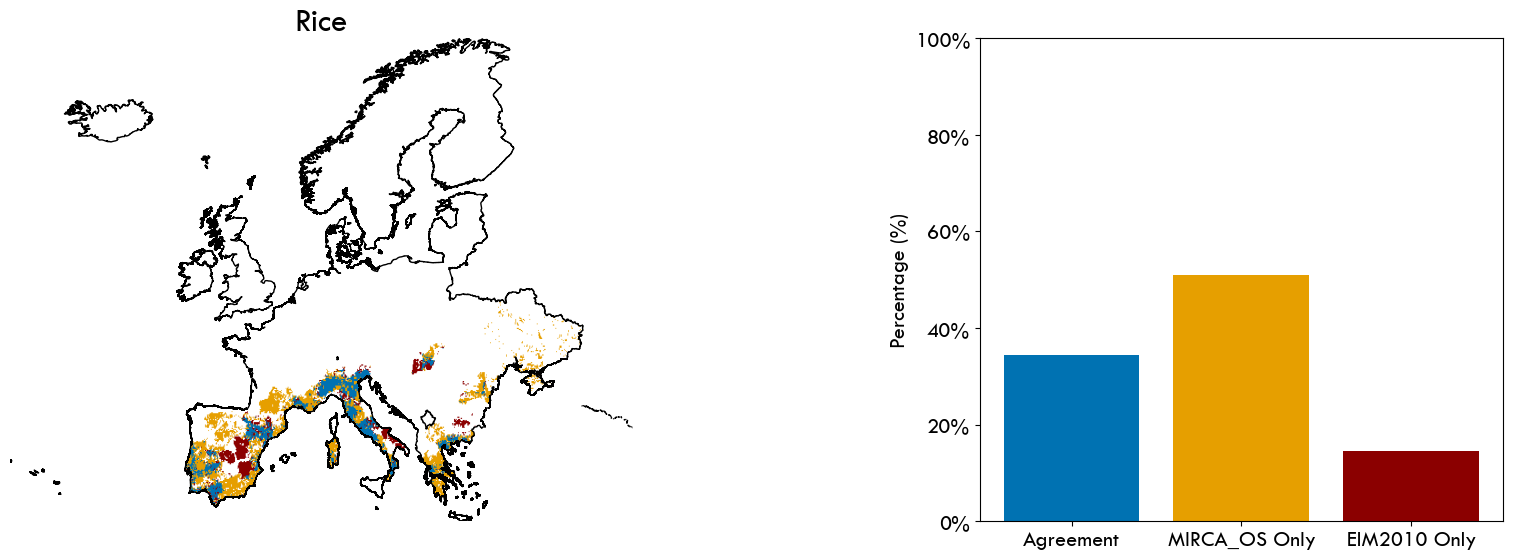

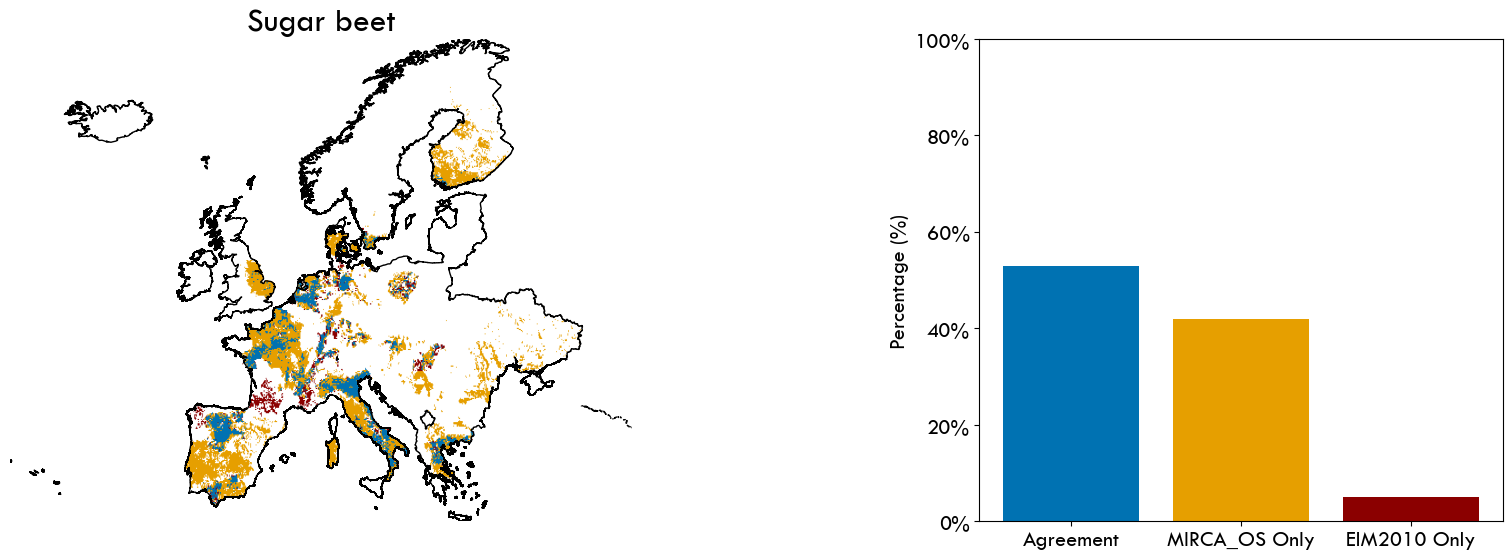

In [36]:
import os
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.patches as mpatches
from matplotlib import font_manager
from rasterio.warp import reproject, Resampling

# Define colorblind-friendly colors for the plot
dark_blue = '#0072B2'  # Dark Blue for agreement
orange = '#E69F00'  # Orange for MIRCA-OS Only
dark_red = '#8B0000'  # Dark Red for MIRCA2000 Only

# Check if 'Tw Cen MT' font is available
if 'Tw Cen MT' not in [f.name for f in font_manager.fontManager.ttflist]:
    print('The "Tw Cen MT" font is not available on your system. Please use an available font or install "Tw Cen MT".')
    title_font = 'sans-serif'
else:
    title_font = 'Tw Cen MT'

# Function to read raster data
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform, src.crs

# Function to reproject and resample raster data to match another raster
def reproject_and_resample(src_data, src_transform, src_crs, dst_shape, dst_transform, dst_crs):
    dst_data = np.zeros(dst_shape, dtype=src_data.dtype)
    reproject(
        source=src_data,
        destination=dst_data,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )
    return dst_data, dst_transform

# Function to get the extent of a raster from its transform
def get_extent(transform, width, height):
    left = transform[2]
    top = transform[5]
    right = left + transform[0] * width
    bottom = top + transform[4] * height
    return (left, right, bottom, top)

# Function to clean raster data
def clean_raster_data(raster_data, extreme_value_threshold=0):
    cleaned_data = np.where(raster_data < extreme_value_threshold, np.nan, raster_data)
    return cleaned_data

# Function to calculate agreement percentages for the bar chart
def calculate_percentages(agree, mirca_os_only, mirca_2000_only):
    agree_count = np.sum(agree)
    mirca_os_only_count = np.sum(mirca_os_only)
    mirca_2000_only_count = np.sum(mirca_2000_only)
    total_valid_pixels = agree_count + mirca_os_only_count + mirca_2000_only_count
    agree_pct = (agree_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    mirca_os_only_pct = (mirca_os_only_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    mirca_2000_pct = (mirca_2000_only_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    return agree_pct, mirca_os_only_pct, mirca_2000_pct

# Function to calculate IoU
def calculate_iou(agree, mirca_os_only, mirca_2000_only):
    intersection = np.sum(agree)
    union = intersection + np.sum(mirca_os_only) + np.sum(mirca_2000_only)
    iou = intersection / union if union > 0 else 0
    return iou

# Load the shapefile and reproject it to WGS84
shapefile_path = "E:\\Europe Validation\\MIRCA_OS\\Export_Output.shp"
shapefile = gpd.read_file(shapefile_path)
shapefile = shapefile.to_crs('EPSG:4326')

# Directories for raster data
base_dir_os = "E:\\Europe Validation\\MIRCA-OS_Clipped"
base_dir_2000 = "E:\\Europe Validation\\Converted_Rasters"

# Crop names
crops = ["Maize", "Potatoes", "Rice", "Sugar beet"]

# Set up the plot dimensions and resolution
figsize = (20, 6)  # Adjusted to include space for the bar chart
dpi = 100  # Adjust the dpi to your preference for resolution

# Create a plot for each crop
for i, crop in enumerate(crops):
    fig, (ax_map, ax_bar) = plt.subplots(1, 2, figsize=figsize, dpi=dpi, gridspec_kw={'width_ratios': [3, 1]})
    
    # Read rasters
    raster1, transform1, crs1 = read_raster(f'{base_dir_os}/{crop}.tif')
    raster2, transform2, crs2 = read_raster(f'{base_dir_2000}/{crop}.tif')

    # Reproject rasters to WGS84
    if crs1 != 'EPSG:4326':
        raster1, transform1 = reproject_and_resample(raster1, transform1, crs1, raster1.shape, transform1, 'EPSG:4326')
    if crs2 != 'EPSG:4326':
        raster2, transform2 = reproject_and_resample(raster2, transform2, crs2, raster1.shape, transform1, 'EPSG:4326')

    # Ensure raster2 has the same dimensions as raster1
    raster2_resampled, _ = reproject_and_resample(
        raster2, transform2, crs2, raster1.shape, transform1, 'EPSG:4326'
    )

    # Clean rasters
    raster1 = clean_raster_data(raster1)
    raster2_resampled = clean_raster_data(raster2_resampled)
    raster1 = np.maximum(raster1, 0)
    raster2_resampled = np.maximum(raster2_resampled, 0)
    
    # Compare rasters
    agree = (raster1 >= 0) & (raster2_resampled >= 0)
    mirca_os_only = (raster1 > 0) & ((raster2_resampled == 0) | np.isnan(raster2_resampled))
    mirca_2000_only = ((raster1 == 0) | np.isnan(raster1)) & (raster2_resampled > 0)

    # Initialize combined RGB array with white background
    combined_rgb = np.ones((raster1.shape[0], raster1.shape[1], 3))

    # Apply new colors based on the comparison
    combined_rgb[agree] = np.array([0, 114, 178]) / 255  # Dark Blue for agreement
    combined_rgb[mirca_os_only] = np.array([230, 159, 0]) / 255  # Orange for MIRCA-OS Only
    combined_rgb[mirca_2000_only] = np.array([139, 0, 0]) / 255  # Dark Red for MIRCA2000 Only

    # Plot map
    extent = get_extent(transform1, raster1.shape[1], raster1.shape[0])
    ax_map.imshow(combined_rgb, extent=extent)
    ax_map.set_title(f'{crop}', fontsize=24, fontname=title_font)
    ax_map.set_frame_on(False)
    shapefile.boundary.plot(ax=ax_map, linewidth=1, edgecolor='black')

    # Remove x and y ticks
    ax_map.set_xticks([])
    ax_map.set_yticks([])

    # Calculate percentages for the bar chart
    agree_pct, mirca_os_only_pct, mirca_2000_pct = calculate_percentages(agree, mirca_os_only, mirca_2000_only)

    # Calculate IoU score
    iou = calculate_iou(agree, mirca_os_only, mirca_2000_only)

    # Plot bar chart on ax_bar
    labels = ['Agreement', 'MIRCA_OS Only', 'EIM2010 Only']
    percentages = [agree_pct, mirca_os_only_pct, mirca_2000_pct]
    ax_bar.bar(labels, percentages, color=[dark_blue, orange, dark_red])
    ax_bar.set_ylabel('Percentage (%)', fontsize=16)
    ax_bar.set_ylim(0, 100)
    ax_bar.set_xticklabels(labels, fontsize=16)
    ax_bar.set_yticklabels([f'{int(tick)}%' for tick in ax_bar.get_yticks()], fontsize=16)

#     # Display IoU score on the bar chart
#     ax_bar.text(1.5, 105, f'IoU: {iou:.2f}', ha='center', va='center', fontsize=20, fontname=title_font, bbox=dict(facecolor='white', edgecolor='none', pad=2.0))

#     # Legend
#     if i == len(crops) - 1:
#         legend_elements = [
#             mpatches.Patch(color=dark_blue, label='Agreement'),
#             mpatches.Patch(color=orange, label='MIRCA-OS Only'),
#             mpatches.Patch(color=dark_red, label='EIM2010 Only')
#         ]
#         plt.figlegend(handles=legend_elements, loc='lower center', ncol=3, fontsize=20, frameon=False, bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to fit your plot and legend inside the figure
    plt.savefig(f'E:\\Europe Validation\\Final Maps\\{crop}_2010.png', bbox_inches='tight')

plt.show()


Crop: Maize, IoU Score: 0.2774
Crop: Potatoes, IoU Score: 0.2072
Crop: Rice, IoU Score: 0.1088
Crop: Sugar beet, IoU Score: 0.1468


In [13]:
import os
import rasterio
import numpy as np
from rasterio.enums import Resampling
from rasterio.warp import reproject, calculate_default_transform

def reproject_raster(src_path, target_crs, target_transform, target_shape):
    """Reproject and resample the raster to match the target CRS, transform, and shape."""
    with rasterio.open(src_path) as src:
        data = np.empty(target_shape, dtype=src.dtypes[0])
        reproject(
            source=rasterio.band(src, 1),
            destination=data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.bilinear
        )

    return data

def clean_data(data):
    """Clean the raster data by setting NaN values and values less than zero to zero."""
    data = np.where(data < 0, 0, data)
    return data

def calculate_iou(raster1, raster2):
    """Calculate the Intersection over Union (IoU) score between two rasters."""
    with rasterio.open(raster1) as src1, rasterio.open(raster2) as src2:
        if src1.crs != src2.crs:
            transform, width, height = calculate_default_transform(
                src2.crs, src1.crs, src2.width, src2.height, *src2.bounds)
            target_crs = src1.crs
            target_transform = transform
            target_shape = (height, width)
        else:
            target_crs = src1.crs
            target_transform = src1.transform
            target_shape = src1.shape

        # Reproject and resample to match target CRS, transform, and shape
        data1, data2 = src1.read(1), reproject_raster(raster2, target_crs, target_transform, target_shape)

        # Clean the data
        data1 = clean_data(data1)
        data2 = clean_data(data2)
        
        intersection = np.logical_and(data1, data2)
        union = np.logical_or(data1, data2)
        
        iou_score = np.sum(intersection) / np.sum(union)
        
    return iou_score

def find_matching_rasters(folder1, folder2):
    """Find and match rasters with the same crop names in two folders."""
    rasters1 = {os.path.splitext(f)[0]: os.path.join(folder1, f) for f in os.listdir(folder1) if f.endswith('.tif')}
    rasters2 = {os.path.splitext(f)[0]: os.path.join(folder2, f) for f in os.listdir(folder2) if f.endswith('.tif')}
    
    matching_rasters = []
    
    for crop_name in rasters1:
        if crop_name in rasters2:
            matching_rasters.append((rasters1[crop_name], rasters2[crop_name]))
            
    return matching_rasters

def main():
    folder1 = "E:\\Europe Validation\\MIRCA-OS_Clipped"
    folder2 = "E:\\Europe Validation\\Converted_Rasters"
    
    matching_rasters = find_matching_rasters(folder1, folder2)
    
    for raster1, raster2 in matching_rasters:
        crop_name = os.path.splitext(os.path.basename(raster1))[0]
        iou_score = calculate_iou(raster1, raster2)
        print(f"Crop: {crop_name}, IoU Score: {iou_score:.4f}")

if __name__ == "__main__":
    main()


Crop: Maize, IoU Score: 0.5347
Crop: Potatoes, IoU Score: 0.4157
Crop: Pulses, IoU Score: 0.1647
Crop: Rapeseed, IoU Score: 0.2495
Crop: Rice, IoU Score: 0.2096
Crop: Sugar beet, IoU Score: 0.3088
Crop: Sunflower, IoU Score: 0.4417


Crop: Maize, Number of valid data points: 15453
Crop: Potatoes, Number of valid data points: 12933
Crop: Pulses, Number of valid data points: 3161
Crop: Rapeseed, Number of valid data points: 2510
Crop: Rice, Number of valid data points: 3547
Crop: Sugar beet, Number of valid data points: 5643
Crop: Sunflower, Number of valid data points: 6839


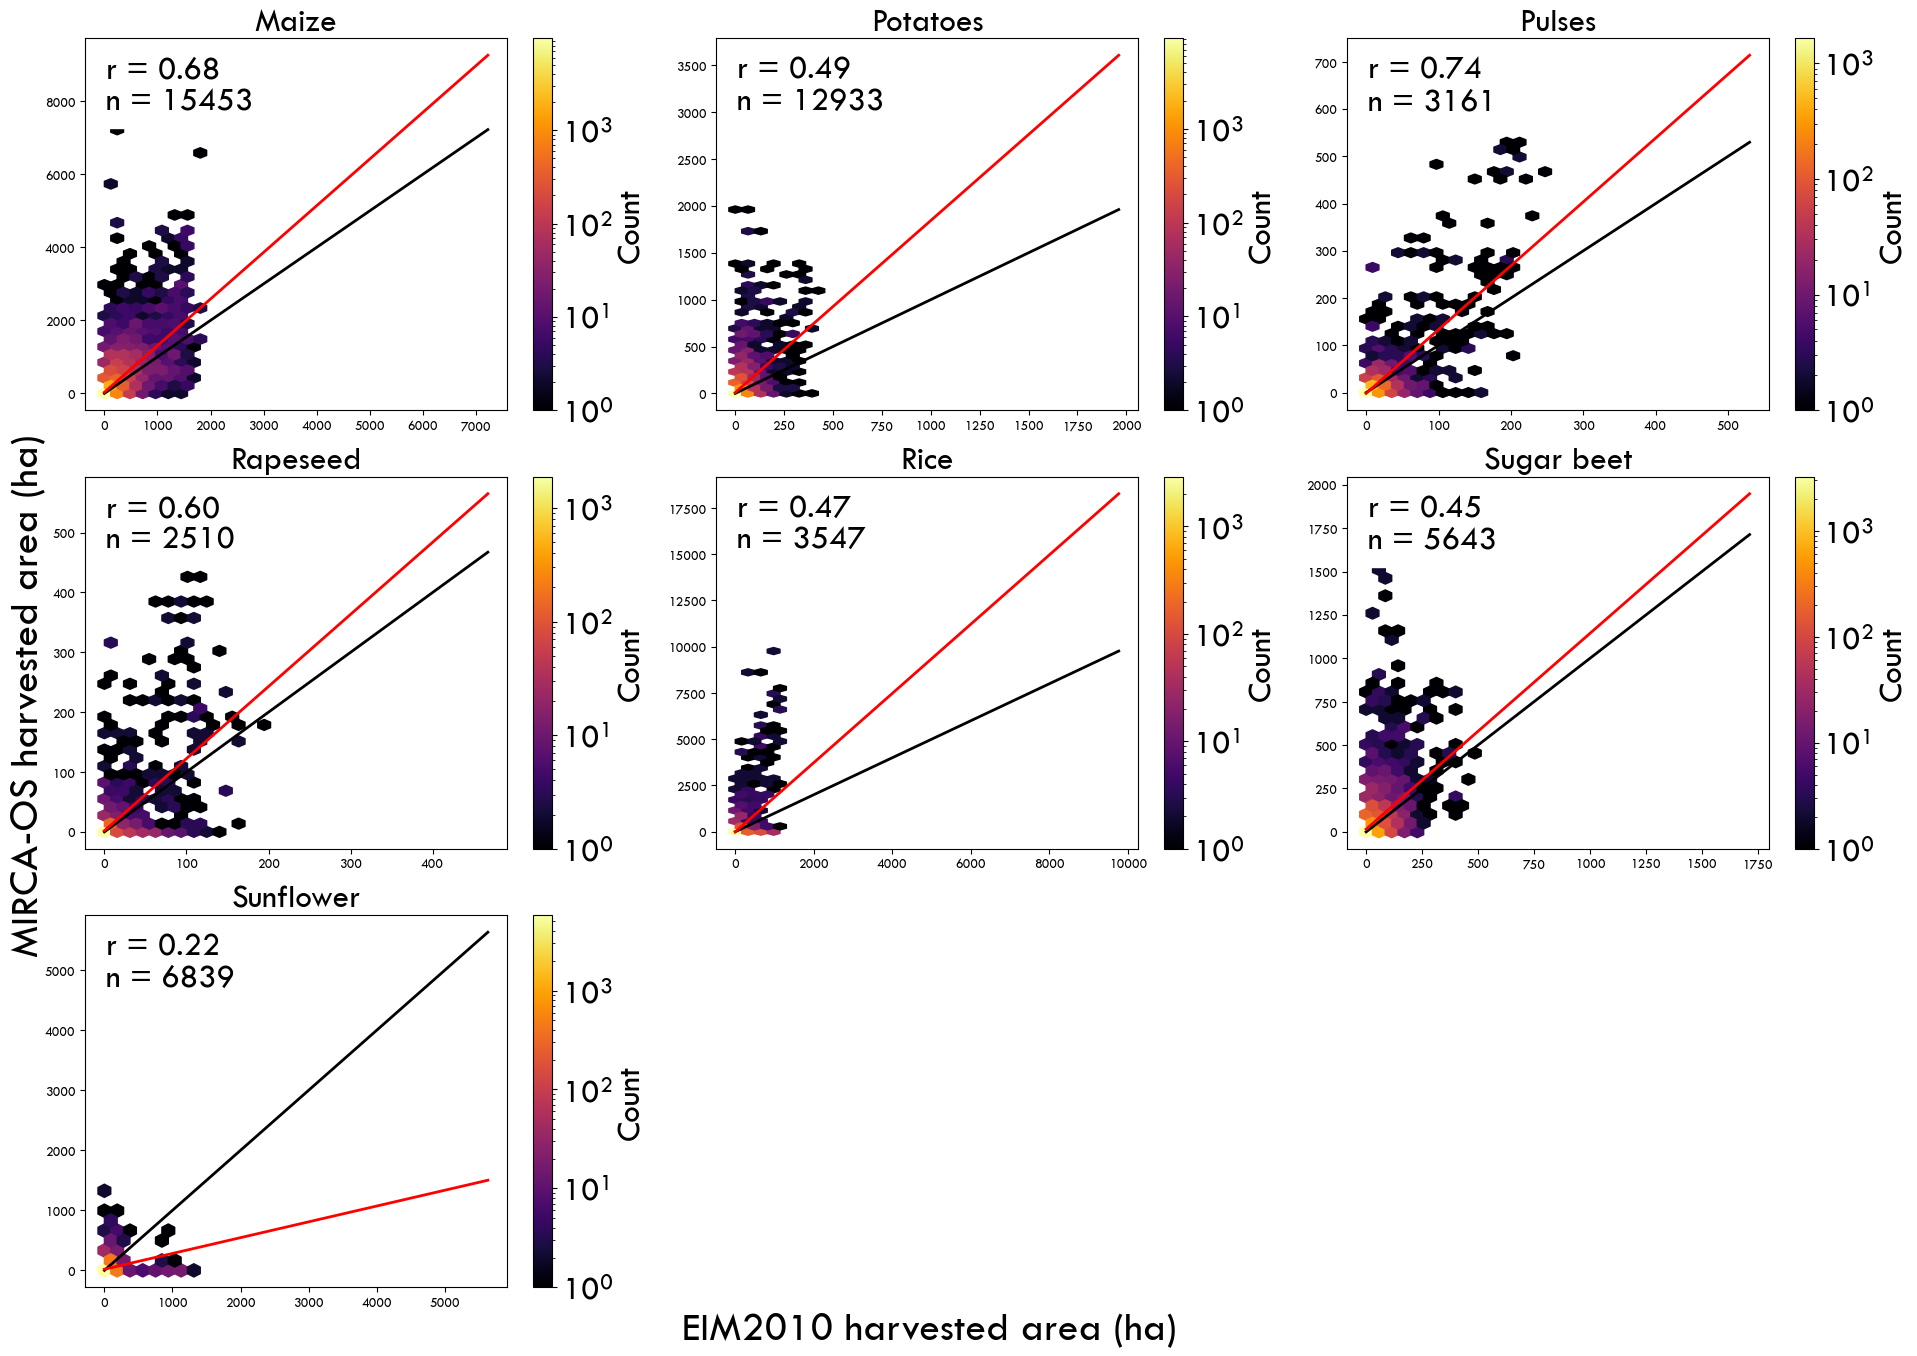

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from scipy.stats import linregress, pearsonr

# Set the font family globally for all plots
plt.rcParams['font.family'] = 'Tw Cen MT'

# Define the base font size
font_size = 24

# Define the clean_raster_data function
def clean_raster_data(raster_data, nan_value):
    """
    Replace the given NaN value in raster data with actual NaNs and zero for negative values.
    """
    raster_data = np.where(raster_data == nan_value, np.nan, raster_data)
    return np.where((raster_data < 0), np.nan, raster_data)

# Define the plot_scatter_and_regression function
def plot_scatter_and_regression(ax, x, y, crop_name, n_valid, common_min, common_max):
    mask = (x != nan_value) & (y != nan_value)
    x = x[mask]
    y = y[mask]
    
    # Calculate the Pearson correlation coefficient
    r, _ = pearsonr(x, y)

    # Create a hexbin plot 
    hb = ax.hexbin(x, y, gridsize=30, cmap='inferno', bins='log', extent=(common_min, common_max, common_min, common_max))
    cbar = ax.figure.colorbar(hb, ax=ax, label='Count')
    cbar.ax.tick_params(labelsize=font_size)  # Set the fontsize for colorbar ticks
    cbar.set_label('Count', size=font_size)  # Set the fontsize for colorbar label

    # Add the 1:1 line
    ax.plot([common_min, common_max], [common_min, common_max], color='black', linestyle='-', linewidth=2)

    # Perform linear regression
    slope, intercept = linregress(x, y)[:2]
    ax.plot([common_min, common_max], [intercept + slope * common_min, intercept + slope * common_max], color='red', linewidth=2)

    # Add text annotation in the plot using axes coordinates
    ax.text(0.05, 0.95, f'r = {r:.2f}\nn = {n_valid}', color='black', ha='left', va='top', 
            backgroundcolor='white', fontsize=font_size, transform=ax.transAxes)

    # Set title
    ax.set_title(f'{crop_name}', fontsize=font_size)


# Define the paths to the directories
folder1 = "E:\\Europe Validation\\MIRCA-OS_Clipped"
folder2 = "E:\\Europe Validation\\EIM2010_2"

# Create a 4x6 subplot layout
fig, axs = plt.subplots(3, 3, figsize=(20, 14)) 
axs = axs.ravel()

# List the raster files
rasters1 = {os.path.splitext(file)[0]: os.path.join(folder1, file) for file in os.listdir(folder1) if file.endswith('.tif')}
rasters2 = {os.path.splitext(file)[0]: os.path.join(folder2, file) for file in os.listdir(folder2) if file.endswith('.tif')}

# Define the NaN value
nan_value = 0

# Iterate over the rasters to plot the data
for i, (crop_name, raster_path1) in enumerate(rasters1.items()):
    if i >= 23:
        break  # Stop after 23 crops
    raster_path2 = rasters2.get(crop_name)
    if raster_path2:
        with rasterio.open(raster_path1) as src1, rasterio.open(raster_path2) as src2:
            # Read the data and apply the cleaning function
            data1 = clean_raster_data(src1.read(1), nan_value)
            data2 = clean_raster_data(src2.read(1), nan_value)

            # Flatten the arrays to create a 1D array for each
            data1 = data1.flatten()
            data2 = data2.flatten()

            # Filter out invalid data points
            valid_mask = (data1 >= 0) & (data2 >= 0)
            data1 = data1[valid_mask]
            data2 = data2[valid_mask]

            # Remove NaN values from both datasets
            mask = ~np.isnan(data1) & ~np.isnan(data2)
            data1 = data1[mask]
            data2 = data2[mask]

            # Calculate the number of valid data points for this crop
            n_valid = len(data1)
            print(f'Crop: {crop_name}, Number of valid data points: {n_valid}')  # Debugging statement

            # Find the min and max values for the current crop
            common_min = min(np.nanmin(data1), np.nanmin(data2))
            common_max = max(np.nanmax(data1), np.nanmax(data2))

            # Find the next available subplot
            ax = axs[i]

            # Plot the data on the corresponding subplot axis
            plot_scatter_and_regression(ax, data1, data2, crop_name, n_valid, common_min, common_max)
            
# Hide the last plot (24th plot)
axs[-2].axis('off')
axs[-1].axis('off')

# Set common x and y labels
fig.text(0.5, 0.04, 'EIM2010 harvested area (ha)', ha='center', fontsize=30)
fig.text(0.04, 0.5, 'MIRCA-OS harvested area (ha)', va='center', rotation='vertical', fontsize=30)

# Adjust the layout and display the plot
plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust rect to fit common labels
plt.savefig(f'E:\\Europe Validation\\Final Maps\\Scatter.png', bbox_inches='tight')
plt.show()
